# Final Model Evaluation Notebook

After collecting and cleaning the data, adding features and performing feature selection, and iterating through a variety of models, I now have my final model: a gradient boost regressor with optimized hyperparameters fit to all of the features with non-zero coefficients after Lasso regression. 

My selection is based on my two major metrics, r-squared and mean absolute error. The business problem that this project addresses is to help sports gamblers make more analytical decisions about their wagers, and these metrics fit that problem in different ways. R-squared shows how well the features in the model capture the variance in the the target, offering a single metric to describe how well the model fits the data. Because mean absolute error presents in the same units as the target, it is highly interpretable even for a non-technical audience and would be easily usable in the context of a betting line. Considering many sports gamblers do not have data science backgrounds, pairing these metrics offers a good blend of robustness and interpretability.

My final model has a mean absolute error of 4.562665 and an r-squared of 0.514145 for the validation data and has a mean absolute error of 4.623410 and an r-squared of 0.544485 for the test data. This suggests that the model explains just over half of the variance in the target and on average is off by just over four and a half points. 

For sports gamblers who want to use this model to inform their bets, knowing the mean absolute error would help because the predictions from this model would need to be 4.62 points above or below the betting line to place the bet with confidence. These numbers may shift slightly when I run the model on all the data, and I provide updates in markdown as the notebook progresses.

I would also advise gamblers who want to use this model that the metrics of the best model tell us to respect the inherent uncertainty in predicting game to game scoring outcomes. Looking at the line plot for a single player provides a simple visualization of how much fluctuation there is on a night to night basis. Further, the best model explains just over half the variance in the target. This shows that there are factors that the model does not consider that play a significant role, factors that could include: injuries to teammates that affect playing time and usage, injuries to opposing players that affect defensive assignments, and chance, among many others.

While respecting the healthy amount of uncertainty inherent in the project, in this notebook, I see how the model performs with the whole data set and further evaluate its performance on subsets of the data. Along the way, I interpret what the findings mean for gamblers who may want to use the model to improve their bets and try to gain as much insight as possible about what the model can and can't say about where to place our bets.

## 1. Imports and Data Preparation

In this section, I use a similar process to the one I used in my modeling notebook to get the data ready to run the final model with all of the data.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('./Data/all_features_clean.csv')

In [3]:
df.head()

,key_0,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,MIN,...,UPCOMING_OPPONENT_TEAM_PCT_PTS_2PT_MR_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_PTS_3PT_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_PTS_FB_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_PTS_FT_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_PTS_OFF_TOV_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_PTS_PAINT_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_UAST_2PM_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_UAST_3PM_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_UAST_FGM_ROLLING,UPCOMING_OPPONENT_TEAM_ABBREVIATION
0,LAL,22015,203952,Andrew Wiggins,1610612750,Minnesota Timberwolves,21500017,2015-10-28,MIN @ LAL,29,...,0.114,0.371,0.086,0.114,0.143,0.400,0.370,0.308,0.350,DEN
1,SAS,22015,201142,Kevin Durant,1610612760,Oklahoma City Thunder,21500013,2015-10-28,OKC vs. SAS,35,...,0.207,0.172,0.138,0.092,0.172,0.529,0.500,0.200,0.459,ORL
2,PHX,22015,1626257,Salah Mejri,1610612742,Dallas Mavericks,21500014,2015-10-28,DAL @ PHX,2,...,0.324,0.162,0.072,0.189,0.198,0.324,0.583,0.167,0.524,LAC
3,NYK,22015,203948,Johnny O'Bryant III,1610612749,Milwaukee Bucks,21500012,2015-10-28,MIL vs. NYK,17,...,0.250,0.239,0.193,0.170,0.159,0.341,0.538,0.286,0.485,WAS
4,OKC,22015,2225,Tony Parker,1610612759,San Antonio Spurs,21500013,2015-10-28,SAS @ OKC,26,...,0.320,0.000,0.080,0.220,0.220,0.460,0.513,0.000,0.513,BKN


In [4]:
numeric_columns = df.select_dtypes(['float', 'int'])

In [5]:
cols_to_remove = ['key_0','SEASON_ID','PLAYER_ID','TEAM_ID','GAME_ID','SEASON_ID_EXPANDING','PLAYER_ID_EXPANDING',
                  'SEASON_ID_ROLLING','PLAYER_ID_ROLLING','UPCOMING_opponent_id', 'UPCOMING_home',
                  'TEAM_GAME_ID','TEAM_ID','opponent_id','opponent_game_id','opponent_id', 'OPPONENT_TEAM_ID',
                  'PLAYER_GAME_ID','target','UPCOMING_OPPONENT_TEAM_ID','UPCOMING_OPPONENT_TEAM_GAME_ID',
                 'UPCOMING_OPPONENT_TEAM_PACE', 'TEAM_PCT_UAST_2PM_ROLLING','TEAM_PACE_EXPANDING',
                 'FGA_PG','FGA_PG_EXPANDING', 'FGA_PG_ROLLING','sp_work_DEF_RATING_ROLLING', 
                  'UPCOMING_OPPONENT_TEAM_PCT_AST_FGM_ROLLING', 'FGM_PG_ROLLING', 'FGM_PG_EXPANDING',
                 'UPCOMING_OPPONENT_TEAM_MIN_ROLLING','UPCOMING_OPPONENT_TEAM_MIN_EXPANDING',
                 'PCT_FGA_2PT_EXPANDING','PCT_FGA_2PT_ROLLING','PCT_FGA_2PT']

In [6]:
selected_cols = [item for item in numeric_columns if item not in cols_to_remove]

I split the data into independent and dependent variables and scale the data in the independent variables.

In [7]:
X = df[selected_cols]
y = df['target']

In [8]:
ss = StandardScaler()

In [9]:
X_scaled = ss.fit_transform(X)

I use lasso to select the features to include.

In [10]:
lasso_model = Lasso(alpha=0.01)

In [11]:
lasso_model.fit(X, y)

C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e+03, tolerance: 1.395e+03
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.01)

In [12]:
coefficients = lasso_model.coef_

In [13]:
feature_names = X.columns

In [14]:
lasso_coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

In [15]:
selected_features = lasso_coefficients_df[lasso_coefficients_df['Coefficient'] != 0]
selected_features.shape

(232, 2)

In [16]:
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)

In [17]:
selected_feature_names = selected_features['Feature'].tolist()

In [18]:
X_lasso = X_scaled_df[selected_feature_names]

With the data prepared, I use my class from the previous notebook to evaluate the final model on all of the data.

## 2. Final Model Performance on All Data

In [19]:
# I adapted this code from code written by David Hartsman for our Flatiron School phase 4 project

class Model():
    model_list = []
    model_df = pd.DataFrame(columns=['Name', 'MSE', 'MAE', 'R2', 'Max Error', 'Explained Variance'])
    
    
    def __init__(self, name, model, X_val, y_val):
        self.name = name
        self.model = model
        self.X_val = X_val
        self.y_val = y_val
        
       # Test metrics
        self.y_pred = self.model.predict(self.X_val)
        
        mse = mean_squared_error(self.y_val, self.y_pred)
        mae = mean_absolute_error(self.y_val, self.y_pred)
        r2 = r2_score(self.y_val, self.y_pred)
        max_err = max_error(self.y_val, self.y_pred)
        evs = explained_variance_score(self.y_val, self.y_pred)
        
        Model.model_list.append(self)
        
        self.attributes = {
            'Name': name,
            'MSE': mse,
            'MAE': mae,
            'R2': r2,
            'Max Error': max_err,
            'Explained Variance': evs
        }
        
        Model.model_df.loc[len(Model.model_df)] = self.attributes
        
    def __repr__(self):
        return f"Model name: {self.name}"
    
    
    @classmethod
    def get_model_list(cls):
        return cls.model_list

In [20]:
final_model = GradientBoostingRegressor(max_depth=5,
                                        max_features='sqrt', 
                                        n_estimators=150,
                                        random_state=42)

In [21]:
final_model.fit(X_lasso,y)

GradientBoostingRegressor(max_depth=5, max_features='sqrt', n_estimators=150,
                          random_state=42)

In [22]:
Model('final_model_all_data', final_model, X_lasso, y)
Model.model_df

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,final_model_all_data,32.16799,4.37597,0.545674,43.481792,0.545674


Working with all of the data, the model has its best performance in terms of mean absolute error at 4.38. The r-squared improves marginally as well at .546. For sports gamblers who would want to use this model to inform their bets, this would mean that a prediction would need to be 4.38 above or below the line to make it outside the range of typical error in the model.

For my final evaluation, I look into how the model performs on different subsets of the data to see if there are certain types of players that the model could help bet on with greater or lesser amounts of confidence.

## 3. Evaluating Model Performance on Subsets of the Data

With my final model finished, I want to see how it performs on certain subsets of the data to see whether it is more or less accurate. I explore in this section.

### 3a. Performance on High Points Outcomes

The first area I look into is how the model performs differently on high points values. I use the top 20th percentile of points outcomes as a cutoff.

In [37]:
percentile_80 = X_lasso['PTS'].quantile(0.80)
percentile_100 = X_lasso['PTS'].quantile(1.0)

In [38]:
high_pts = X_lasso['PTS'][(X_lasso['PTS'] >= percentile_80) & (X_lasso['PTS'] <= percentile_100)]

In [39]:
high_pts_index = high_pts.index

In [40]:
y_high_pts = y.loc[high_pts_index]

In [46]:
X_high_pts = X_lasso.loc[high_pts_index]

In [48]:
high_pts_predictions = final_model.predict(X_high_pts)

In [74]:
mae_high = mean_absolute_error(y_high_pts, high_pts_predictions)
mae_high

5.501941255696821

In [75]:
r2_high = r2_score(y_high_pts, high_pts_predictions)
r2_high

0.42578875668594174

This is not too surprising because the more points players tend to score, the more variance there is likely to be. However, it is instructive-- when looking at scoring in the top 20% of outcomes, the mean absolute error increases and the amount of variance in the target that the model can explain decreases. Before doing too much interpretation, I want to see how the model performs on low scoring performances and mid scoring performances as well.

### 3b. Performance on Low Points Outcomes

The next area I look into is how the model performs differently on low points values. I use the bottom 20th percentile of points outcomes as a cutoff.

In [52]:
percentile_0 = X_lasso['PTS'].quantile(0.0)
percentile_20 = X_lasso['PTS'].quantile(0.2)

In [53]:
low_pts = X_lasso['PTS'][(X_lasso['PTS'] >= percentile_0) & (X_lasso['PTS'] <= percentile_20)]

In [54]:
low_pts_index = low_pts.index

In [55]:
y_low_pts = y.loc[low_pts_index]

In [56]:
X_low_pts = X_lasso.loc[low_pts_index]

In [57]:
low_pts_predictions = final_model.predict(X_low_pts)

In [76]:
mae_low = mean_absolute_error(y_low_pts, low_pts_predictions)
mae_low

3.392194390369756

In [77]:
r2_low = r2_score(y_low_pts, low_pts_predictions)
r2_low

0.2499184528536439

Once again, the results are not too surprising in the sense that the mean absolute error was lower for lower scoring performances. Again, I want to see all of the subsets before interpreting results.

### 3c. Performance on Mid Points Outcomes

In [60]:
mid_pts = X_lasso['PTS'][(X_lasso['PTS'] > percentile_20) & (X_lasso['PTS'] < percentile_80)]

In [61]:
mid_pts_index = mid_pts.index

In [67]:
y_mid_pts = y.loc[mid_pts_index]

In [68]:
X_mid_pts = X_lasso.loc[mid_pts_index]

In [69]:
mid_pts_predictions = final_model.predict(X_mid_pts)

In [71]:
mean_absolute_error(y_mid_pts, mid_pts_predictions)

4.365206657317364

In [73]:
r2_score(y_mid_pts, mid_pts_predictions)

0.3650875157569128

The results for mean absolute error are not surprising here as well. It is interesting that the r2 for each subset is lower than the r2 for the entire data set, often by a substantial amount. This makes sense as well, though, because the cut offs for how I defined the subset could be splitting the data in a way that hurts model performance. In general, the biggest trend here is that the model tends to have a lower mean absolute error for lower scoring outcomes than it does for higher scoring outcomes. This could potentially help gamblers by focusing on lines for low or mid scoring players.

After subsetting the data by points, I want to see how the model performs over the course of a given season.

### 3d. Evaluating Errors Over Time

One final subset I want to take a look at is how the model handles errors over time. I create columns for predictions and absolute errors and then take the median absolute error by month. My expectation is that the model would perform worst at the beginning of the season because the rolling and expanding averages would be the least stable early on.

In [79]:
X_lasso['predictions'] = final_model.predict(X_lasso)

C:\Users\Hendricks\AppData\Local\Temp\ipykernel_11904\562231813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_lasso['predictions'] = final_model.predict(X_lasso)


In [81]:
X_lasso['errors'] = abs(y - X_lasso['predictions'])

C:\Users\Hendricks\AppData\Local\Temp\ipykernel_11904\4063047997.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_lasso['errors'] = abs(y - X_lasso['predictions'])


In [106]:
X_lasso['game_date'] = pd.to_datetime(df['GAME_DATE'])

C:\Users\Hendricks\AppData\Local\Temp\ipykernel_11904\2895958754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_lasso['game_date'] = pd.to_datetime(df['GAME_DATE'])


In [122]:
errors_series = X_lasso.groupby(X_lasso['game_date'].dt.month)['errors'].median()

In [123]:
errors_series

game_date
1     3.541990
2     3.567158
3     3.556216
4     3.717529
5     3.695218
7     3.669437
8     3.889038
10    3.387429
11    3.450751
12    3.468807
Name: errors, dtype: float64

In [129]:
reordered_index = errors_series.reindex([10, 11, 12, 1, 2, 3, 4, 5, 7, 8])

In [130]:
reordered_index

game_date
10    3.387429
11    3.450751
12    3.468807
1     3.541990
2     3.567158
3     3.556216
4     3.717529
5     3.695218
7     3.669437
8     3.889038
Name: errors, dtype: float64

C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

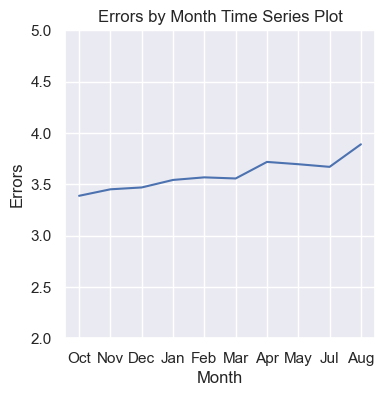

In [140]:
sns.set(style="darkgrid")
plt.figure(figsize=(4, 4))
sns.lineplot(x = range(1, 11), y = reordered_index.values)
plt.xlabel('Month')
plt.xticks(range(1, 11), ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jul', 'Aug'])
plt.ylabel('Errors')
plt.ylim(2, 5)
plt.title('Errors by Month Time Series Plot')
plt.show()

Unexpectedly, the error for the model is actually the lowest at the start of the season and gets slightly higher as the season goes along, although generally the error is fairly stable throughout the season. This could be because teams tend to be healthiest at the start of the year; as games accumulate, injuries accumulate as well and change the context for performance. I also notice that by using the median error instead of the mean, the average error drops substantially from about 4.4 to about 3.5. This suggests that the mean average error may be inflated by extremely wrong predictions because the mean is more sensitive to outliers than the median is. From a gambling perspective, it would make more sense to look at the median because it does not matter if a prediction is a little bit wrong or very wrong-- a win is a win and a loss is a loss. Using the median suggests that the model could be used to place bets when the prediction is 3.5 points above or below the line; based on what I learned subsetting by points, that may have to be adjusted up or down depending upon how many points the player usually scores.


July and August have the highest errors, which makes sense because those games all come from the season that was interrupted by the COVID-19 pandemic. With a smaller sample, it makes sense that the model performs worse.  I make one final plot to visualize the error by month without those irregular months.

C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

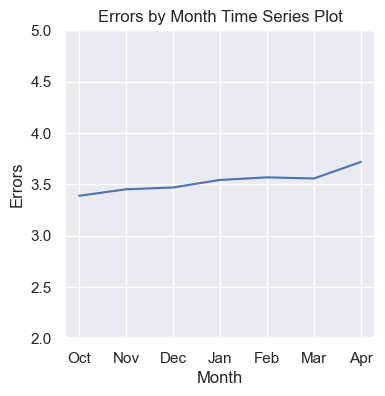

In [142]:
sns.set(style="darkgrid")
plt.figure(figsize=(4, 4))
sns.lineplot(x = range(1, 8), y = reordered_index[:7].values)
plt.xlabel('Month')
plt.xticks(range(1, 8), ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'])
plt.ylabel('Errors')
plt.ylim(2, 5)
plt.title('Errors by Month Time Series Plot')
plt.show()

## 4. Final Thoughts and Next Steps

One major takeaway from this project is to be able to describe the level of uncertainty that exists when making predictions about player scoring. Using publicly available data and not taking player availability into account, it is possible to account for a little over half of the variation in night to night scoring variation. It is possible to predict a player's points in the upcoming game with a mean average error of around 4.4 points and a median average error of around 3.5 points. The error is higher for players who score more and lower for players who score less, and the error stays relatively stable throughout the season. Simply knowing that context helps create a more informed approach to wagering on single-game player scoring outcomes because it allows gamblers to approach the inherent uncertainty with more certainty.

I have five major next steps for the project. First, I would want to further tune the LSTM neural network that I tried at the end of the project to see if it could handle the time-series part of the data better. Second, I would want to try a rolling window split instead of a sequential split to see if that could improve model performance. Third, I would want to add betting lines to see if that could help the model make predictions and to add a classification component to the project to see how often the model's predictions are correct in terms of identifying if the outcome was above or below the line. Fourth, I would want to add an end to end pipeline so that the model can seamlessly handle live data and make predictions for the upcoming season. Finally, I would want to deploy the model so that people can see the predictions and results.

Overall, I learned so much from doing this project, and I hope that it contributes even in some small way to support those tens of millions of sports gamblers in the USA in making wiser wagers.